In [21]:
%matplotlib inline
import scipy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import scipy

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid, sub_sample_data

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import functools

import scipy

# from sklearn import datasets
# from sklearn.preprocessing import LabelBinarizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
    beta = 0.2
    r = 0.6
    delta = 0.15
    theta_t = np.array([beta, r, delta]) # true parameter settings
    #theta = np.random.randn(3)
    print(theta)
    
    
    
    

[0.2  0.6  0.15]


In [24]:
def odeFunc(t,x):
    N = 1000
    S = x[0]
    I = x[1]
    R = x[2]
    y0 = delta*N - delta*S - beta*I*S  # del S
    y1 = beta*I*S - (r+delta)*I        # del I
    y2 = r*I - delta*R                 # del R
    return y0,y1,y2

In [25]:
def solverFunc():
    timeVec = np.linspace(0,6,61)
    S_0 = 900
    I_0 = 100
    R_0 = 0
    x_0 = np.array([S_0, I_0, R_0])
    soln = scipy.integrate.solve_ivp(odeFunc,[0,6],x_0,t_eval=timeVec,method='RK45')
    return soln

In [26]:
soln = solverFunc()
data1 = np.zeros([61,1])
stdNoise = 50 
for ii in range (0,len(data1)):
    data1[ii]=soln.y[1,ii]+stdNoise*np.random.randn()

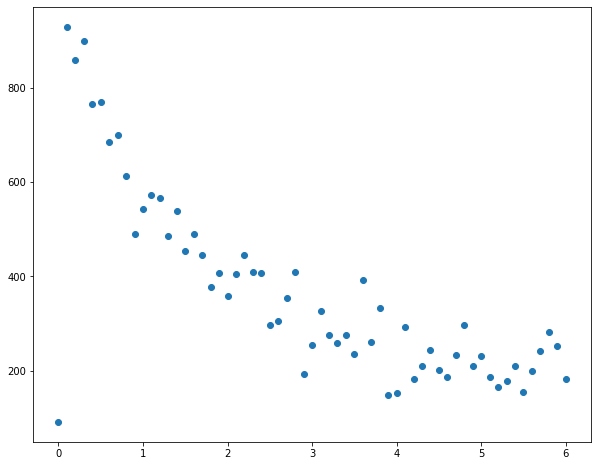

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(soln.t,data1)
plt.show()

In [14]:
# theta0 = np.random.randn(3)
# print(theta0)

In [8]:
def SIR(t, y, beta, r, delta, N=1000):
    #S, I, R = y
    dSdt = delta*N - delta*y[0] - beta*y[1]*y[0]
    dIdt = beta*y[1]*y[0] - (r+delta)*y[1]
    dRdt = r*y[1] - delta*y[2]
    
    return dSdt, dIdt, dRdt



In [73]:
def log_likelihood(thetain,data):
    timeVec = np.linspace(0,6,61)
    beta = thetain[0]
    r = thetain[1]
    delta = thetain[2]
    S_0 = 900
    I_0 = 100
    R_0 = 0
    N = 1000
    x_0 = np.array([S_0, I_0, R_0])
#     soln = scipy.integrate.solve_ivp(odeFunc,[0,6],x_0,t_eval=timeVec, args=(beta, r, delta),method='RK45')
    sol = scipy.integrate.solve_ivp(odeFunc, [0,6], y0=x_0, method='RK45', t_eval=timeVec)

    #if np.any(soln.y<0) or np.any(soln.y>N)
    #return 0
#     print(np.round(np.sum(soln.y,axis=0)))
#     if np.any(np.round(np.sum(soln.y,axis=0))!=N):
#         return -np.inf
    if thetain[0] >= 0 and thetain[1] >= 0 and thetain[2] >= 0:
        std = 50
        pre_exp_term = 1/(np.sqrt(2*np.pi)*std)
        exp_term = -0.5*np.square((data.T-soln.y[1])/std)
#     f = pre_exp_term*np.exp(exp_term)
        f = np.log(pre_exp_term)+exp_term
#         f = np.log(scipy.stats.norm.pdf(soln.y[1,:],data.T, std))
  
    
#         f = np.log(scipy.stats.norm.pdf(data, soln.y[1], std))
        
        f = np.zeros(len(sol.y[1,:]))
        for ii in range(len(sol.y[1,:])):
             f[ii] = np.log(scipy.stats.norm.pdf(sol.y[1,ii],data[ii], std))


        f_theta0 = (np.log(scipy.stats.norm.pdf(thetain[0],0,1)))
        f_theta1 = (np.log(scipy.stats.norm.pdf(thetain[1],0,1)))
        f_theta2 = (np.log(scipy.stats.norm.pdf(thetain[2],0,1)))
        f_theta = np.sum(np.array([f_theta0, f_theta1, f_theta2]))
        out=np.sum(f) + f_theta
        
    else:
        return -np.inf
        

    return out

In [70]:
logpost = lambda params: log_likelihood(params, data1)

In [71]:
def logmultivargaussianPDF(x,y,cov):
        logpdf = np.log(np.exp(-0.5*np.dot((x-y).T,np.dot(np.linalg.inv(cov),(x-y))))*1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov)))) 
        return logpdf

In [64]:
class DelayedRejectionAdaptiveMetropolis:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.38**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
        self.sample_mean = self.samples[0,:]
        
    def sample(self, initial_sample, num_samples):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        
        accept = 1
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
        
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                qterm1 = multiVarLogPDF(y,y2,self.cov)
                qterm2 = multiVarLogPDF(y,self.samples[ii-1, :],self.cov) 
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + qterm1 - qterm2)
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            self.num_samples += 1
            #print(ii, accept / self.num_samples, self.samples[ii, :])
             
            
            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:                          
                sample_mean_new = (1/(ii+1))*self.samples[ii, :]+(ii/(ii+1))*self.sample_mean
                update_term = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - (
                    ii+1)*np.dot(sample_mean_new,sample_mean_new) + np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*update_term/ii 
                self.cov_chol = np.linalg.cholesky(self.cov)
                self.sample_mean = sample_mean_new
        
                                
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
                
        return self.samples

In [65]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [66]:
def multiVarLogPDF(x,y,cov):
    mu = np.array([0, 0])
    x_mu = x-y
    logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))*np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))
    return logpdf

In [74]:
num_samples = 10000
dim=3
guess = np.random.randn((dim)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpost)
# initial_sample = map_point
covin = cov_laplace
print(cov_laplace)
print(map_point)
initial_sample=np.array([0.015, .7, .25])
# initial_sample=theta_t
covin = np.diag(np.array([1e-3, 1e-3, 1e-3]))
covin = np.array([[3.13e-06, -1.3e-05, -3.9e-06],[-1.3e-05, 5.6e-04,1.6e-04],[-3.9e-06,1.6e-04,9.1e-05]])
print(covin)

data = data1
# dram = DelayedRejectionAdaptiveMetropolis(logpost, cov, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)
dram = DelayedRejectionAdaptiveMetropolis(logpost, covin, freq=5, t0=300, sd = None, eps = 1e-7, max_samples=num_samples)
#dram = DRAM(log_likelihood_I, covin, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)


samples = dram.sample(theta_t,num_samples)
print(samples)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-pack

[[ 0.94459056  0.00254053 -0.21054189]
 [ 0.00254053  0.9947425  -0.02079664]
 [-0.21054189 -0.02079664  0.89056417]]
[6.44193208e-06 1.94334115e-06 4.56465255e-06]
[[ 3.13e-06 -1.30e-05 -3.90e-06]
 [-1.30e-05  5.60e-04  1.60e-04]
 [-3.90e-06  1.60e-04  9.10e-05]]


/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_1211/1269898578.py:59: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + qterm1 - qterm2)


Finished sample 1000, acceptance ratio = 0.844
Finished sample 2000, acceptance ratio = 0.72
Finished sample 3000, acceptance ratio = 0.651
Finished sample 4000, acceptance ratio = 0.61625
Finished sample 5000, acceptance ratio = 0.599
Finished sample 6000, acceptance ratio = 0.5901666666666666
Finished sample 7000, acceptance ratio = 0.5788571428571428
Finished sample 8000, acceptance ratio = 0.58125
Finished sample 9000, acceptance ratio = 0.5772222222222222
[[0.2        0.6        0.15      ]
 [0.20069264 0.60387217 0.15110843]
 [0.19971625 0.5847003  0.15648775]
 ...
 [0.10650667 1.02725694 0.17335513]
 [0.10650667 1.02725694 0.17335513]
 [0.10650667 1.02725694 0.17335513]]


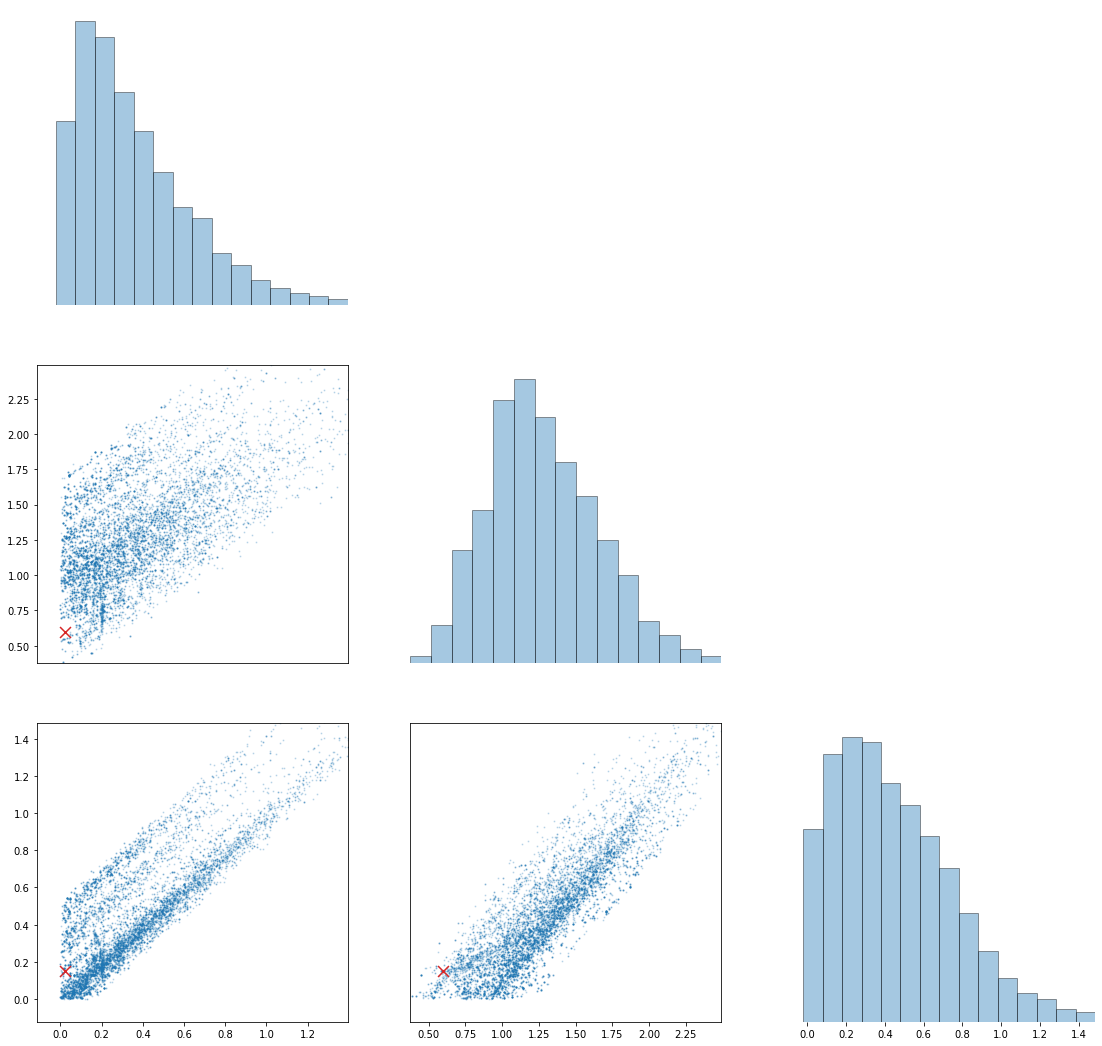

In [76]:
samples_sub = sub_sample_data(samples, frac_burn=0.5, frac_use=0.7)
fig, axs, gs = scatter_matrix([samples], hist_plot=False, gamma=0.2)


axs[3].scatter(.02, .6, color='tab:red', s=120, zorder=3, marker='x')
axs[6].scatter(.02, .15, color='tab:red', s=120, zorder=3, marker='x')
axs[7].scatter(.6, .15, color='tab:red', s=120, zorder=3, marker='x')


fig.set_size_inches(15,15)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)

In [20]:
dim = 3
#fig = plt.figure()
guess = np.random.randn((dim)) # random guess
#guess = np.array([1,2])
map_point, cov_laplace = laplace_approx(guess, logpost)
#print(cov_laplace)
# plot_banana()
# plt.scatter(map_point[0],map_point[1])
print(map_point)
print(cov_laplace)

NameError: name 'data' is not defined